In [1]:
import torch
from torch.utils.data import Dataset
from typing import Tuple
import numpy as np
import requests
import pandas as pd

#### LOADING THE MODEL

from torchvision.models import resnet18

### Add this as a transofrmation to pre-process the images
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA.pt", map_location="cpu")

model.load_state_dict(ckpt)

/home/saqib/libs/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saqib/libs/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple

# Define normalization parameters
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

# Define normalization transform ONLY
image_transform = transforms.Normalize(mean=mean, std=std)

#### DATASETS
class TaskDataset(Dataset):
    def __init__(self, transform=None):
        self.ids = []
        self.imgs = []    # Should contain PIL.Image or raw image tensors
        self.labels = []
        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]

# Example: loading public data and applying transform
public_data = torch.load("pub.pt", weights_only=False)
public_data.transform = image_transform

private_data = torch.load("priv_out.pt", weights_only=False)
private_data.transform = image_transform

# EDA on public dataset

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

print(f"Total samples: {len(public_data)}")

# Extract labels and membership
labels = [public_data[i][2] for i in range(len(public_data))]
membership = [public_data[i][3] for i in range(len(public_data))]

label_counts = Counter(labels)
membership_counts = Counter(membership)

print("Label distribution:", label_counts)
print("Membership distribution (0=non-member, 1=member):", membership_counts)

Total samples: 20000
Label distribution: Counter({17: 3281, 41: 2817, 21: 2324, 36: 1984, 12: 951, 37: 776, 11: 737, 25: 681, 29: 635, 15: 634, 31: 613, 5: 553, 6: 483, 27: 467, 22: 454, 40: 450, 20: 448, 10: 301, 7: 211, 19: 130, 18: 121, 38: 120, 33: 97, 4: 87, 9: 55, 8: 53, 28: 51, 13: 46, 43: 45, 14: 40, 39: 39, 32: 35, 26: 34, 3: 33, 42: 33, 1: 31, 34: 28, 24: 28, 23: 27, 0: 26, 2: 21, 30: 9, 16: 7, 35: 4})
Membership distribution (0=non-member, 1=member): Counter({0: 10000, 1: 10000})


In [36]:
print(f"Number of unique labels: {len(label_counts)}")
print(f"Labels with less than 10 samples: {[k for k, v in label_counts.items() if v < 10]}")

Number of unique labels: 44
Labels with less than 10 samples: [30, 35, 16]


In [37]:
unique_labels_sorted = sorted(label_counts.keys())
print("Unique labels sorted:", unique_labels_sorted)

Unique labels sorted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


Text(0.5, 1.0, 'Label Distribution')

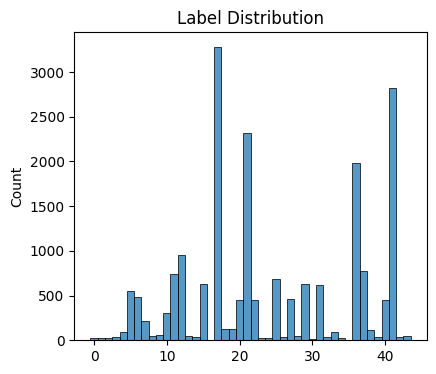

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 4))

# Label distribution
plt.subplot(1, 2, 1)
sns.histplot(labels, bins=len(set(labels)), discrete=True)
plt.title("Label Distribution")

In [43]:
import pandas as pd
from collections import defaultdict

# Create a summary DataFrame from the dataset
records = []

for i in range(len(public_data)):
    _, _, label, membership = public_data[i]
    records.append((label, membership))

df = pd.DataFrame(records, columns=["label", "membership"])
# Group by label and membership status (0 or 1)
distribution = df.groupby(['label', 'membership']).size().unstack(fill_value=0)
distribution.columns = ['Non-Member', 'Member']  # assuming 0 = non-member, 1 = member
distribution = distribution.sort_index()

print(distribution)

       Non-Member  Member
label                    
0              17       9
1              18      13
2              10      11
3              18      15
4              42      45
5             290     263
6             230     253
7             115      96
8              23      30
9              29      26
10            147     154
11            360     377
12            500     451
13             21      25
14             22      18
15            287     347
16              3       4
17           1619    1662
18             66      55
19             71      59
20            222     226
21           1190    1134
22            223     231
23             17      10
24             18      10
25            331     350
26             18      16
27            225     242
28             27      24
29            305     330
30              4       5
31            313     300
32             21      14
33             44      53
34             15      13
35              3       1
36          

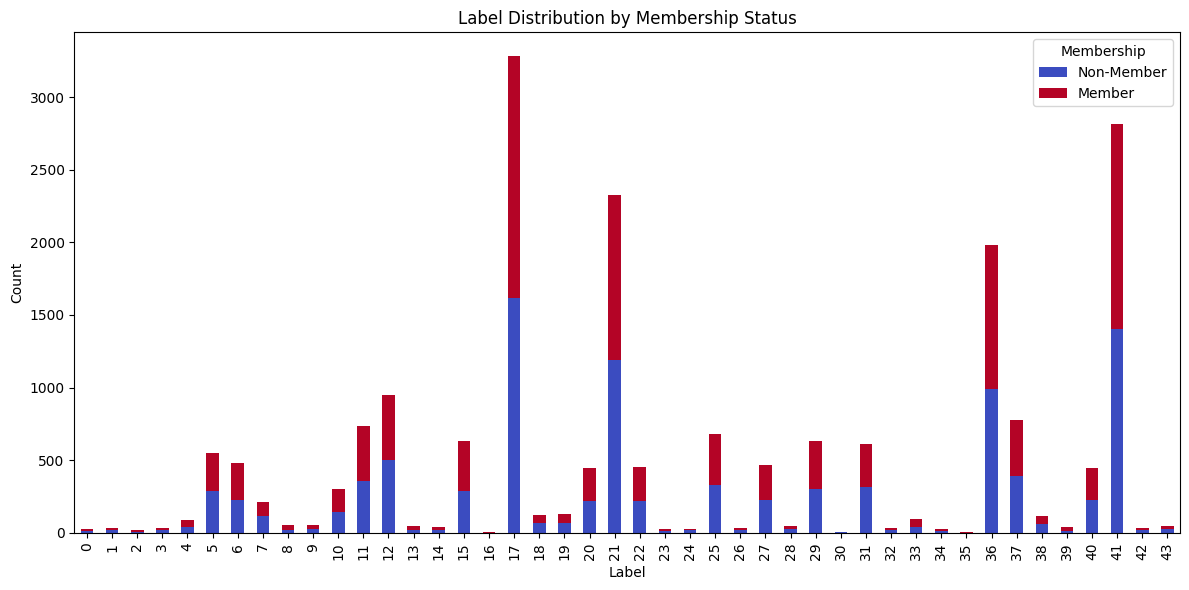

In [44]:
import matplotlib.pyplot as plt

distribution.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Label Distribution by Membership Status")
plt.xlabel("Label")
plt.ylabel("Count")
plt.legend(title="Membership")
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd

# Extract (label, membership) pairs from dataset
records = [(public_data[i][2], public_data[i][3]) for i in range(len(public_data))]
df = pd.DataFrame(records, columns=["label", "membership"])

# Count by label and membership (0 = non-member, 1 = member)
counts = df.groupby(['label', 'membership']).size().unstack(fill_value=0)
counts.columns = ['non_member_count', 'member_count']
counts['total'] = counts.sum(axis=1)

# Calculate percentages per label
counts['%_members'] = (counts['member_count'] / counts['total']) * 100
counts['%_non_members'] = (counts['non_member_count'] / counts['total']) * 100

# Overall totals
overall = pd.DataFrame({
    'non_member_count': [counts['non_member_count'].sum()],
    'member_count': [counts['member_count'].sum()]
})
overall['total'] = overall.sum(axis=1)
overall['%_members'] = (overall['member_count'] / overall['total']) * 100
overall['%_non_members'] = (overall['non_member_count'] / overall['total']) * 100
overall.index = ['TOTAL']

# Combine per-label counts with overall totals
full_table = pd.concat([counts, overall])

pd.set_option("display.max_rows", 50)  # Show all labels if needed
print(full_table)

       non_member_count  member_count  total  %_members  %_non_members
0                    17             9     26  34.615385      65.384615
1                    18            13     31  41.935484      58.064516
2                    10            11     21  52.380952      47.619048
3                    18            15     33  45.454545      54.545455
4                    42            45     87  51.724138      48.275862
5                   290           263    553  47.558770      52.441230
6                   230           253    483  52.380952      47.619048
7                   115            96    211  45.497630      54.502370
8                    23            30     53  56.603774      43.396226
9                    29            26     55  47.272727      52.727273
10                  147           154    301  51.162791      48.837209
11                  360           377    737  51.153324      48.846676
12                  500           451    951  47.423764      52.576236
13    

# EDA on private dataset

In [34]:
from collections import Counter
import matplotlib.pyplot as plt

print(f"Total samples: {len(private_data)}")

# Extract labels and membership
labels = [private_data[i][2] for i in range(len(private_data))]
membership = [private_data[i][3] for i in range(len(private_data))]

label_counts = Counter(labels)
membership_counts = Counter(membership)

print("Label distribution:", label_counts)
print("Membership distribution (0=non-member, 1=member):", membership_counts)

Total samples: 20000
Label distribution: Counter({17: 3305, 41: 2645, 21: 2346, 36: 2004, 12: 952, 37: 786, 11: 767, 25: 708, 31: 660, 29: 648, 15: 573, 5: 549, 20: 499, 27: 489, 22: 483, 40: 462, 6: 450, 10: 271, 7: 221, 38: 145, 19: 123, 18: 113, 33: 105, 4: 76, 8: 62, 28: 47, 9: 47, 13: 45, 34: 42, 39: 35, 24: 34, 1: 34, 0: 32, 32: 32, 14: 31, 43: 29, 23: 29, 3: 27, 26: 26, 42: 25, 2: 23, 30: 10, 16: 6, 35: 4})
Membership distribution (0=non-member, 1=member): Counter({None: 20000})


In [25]:
print(f"Number of unique labels: {len(label_counts)}")
print(f"Labels with less than 10 samples: {[k for k, v in label_counts.items() if v < 10]}")

Number of unique labels: 44
Labels with less than 10 samples: [16, 35]


In [26]:
unique_labels_sorted = sorted(label_counts.keys())
print("Unique labels sorted:", unique_labels_sorted)

Unique labels sorted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


Text(0.5, 1.0, 'Label Distribution')

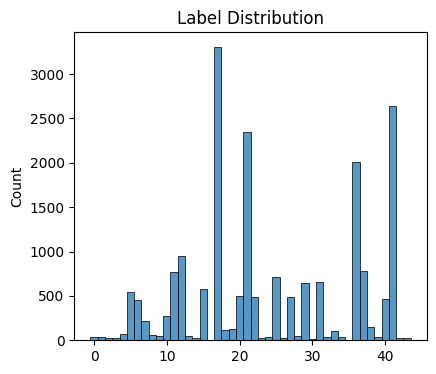

In [27]:
import seaborn as sns

plt.figure(figsize=(10, 4))

# Label distribution
plt.subplot(1, 2, 1)
sns.histplot(labels, bins=len(set(labels)), discrete=True)
plt.title("Label Distribution")

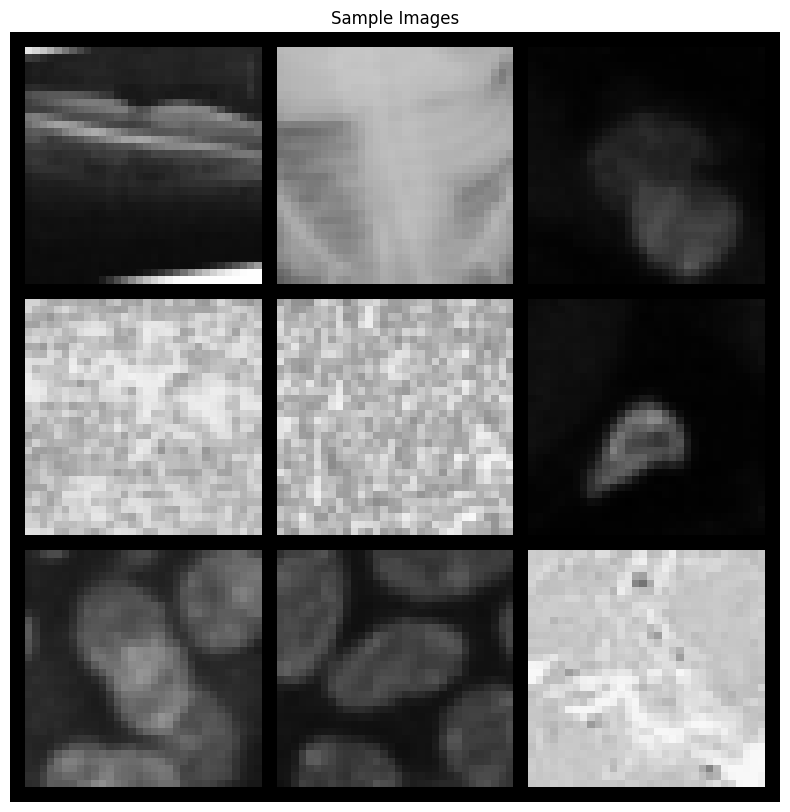

In [28]:
import torchvision
import torchvision.transforms as T
import torch

def show_images(dataset, n=9):
    indices = torch.randint(0, len(dataset), (n,))
    imgs = []
    titles = []
    for idx in indices:
        id_, img, label, mem = dataset[idx]
        if isinstance(img, torch.Tensor) and img.dim() == 3:
            imgs.append(img)
            titles.append(f"Label: {label}, Mem: {mem}")
    
    grid = torch.stack(imgs)
    grid = torchvision.utils.make_grid(grid, nrow=3, normalize=True, value_range=(0, 1))

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Sample Images")
    plt.show()

show_images(private_data)

In [29]:
img_shapes = [data[i][1].shape for i in range(100)]  # sample first 100
unique_shapes = set(img_shapes)
print(f"Unique image shapes: {unique_shapes}")

# Check mean/std for 100 images
all_imgs = torch.stack([data[i][1] for i in range(100)])
print("Mean per channel:", all_imgs.mean(dim=[0, 2, 3]))
print("Std per channel:", all_imgs.std(dim=[0, 2, 3]))

Unique image shapes: {torch.Size([3, 32, 32])}
Mean per channel: tensor([0.3511, 0.2836, 0.3293])
Std per channel: tensor([0.3257, 0.2561, 0.2995])


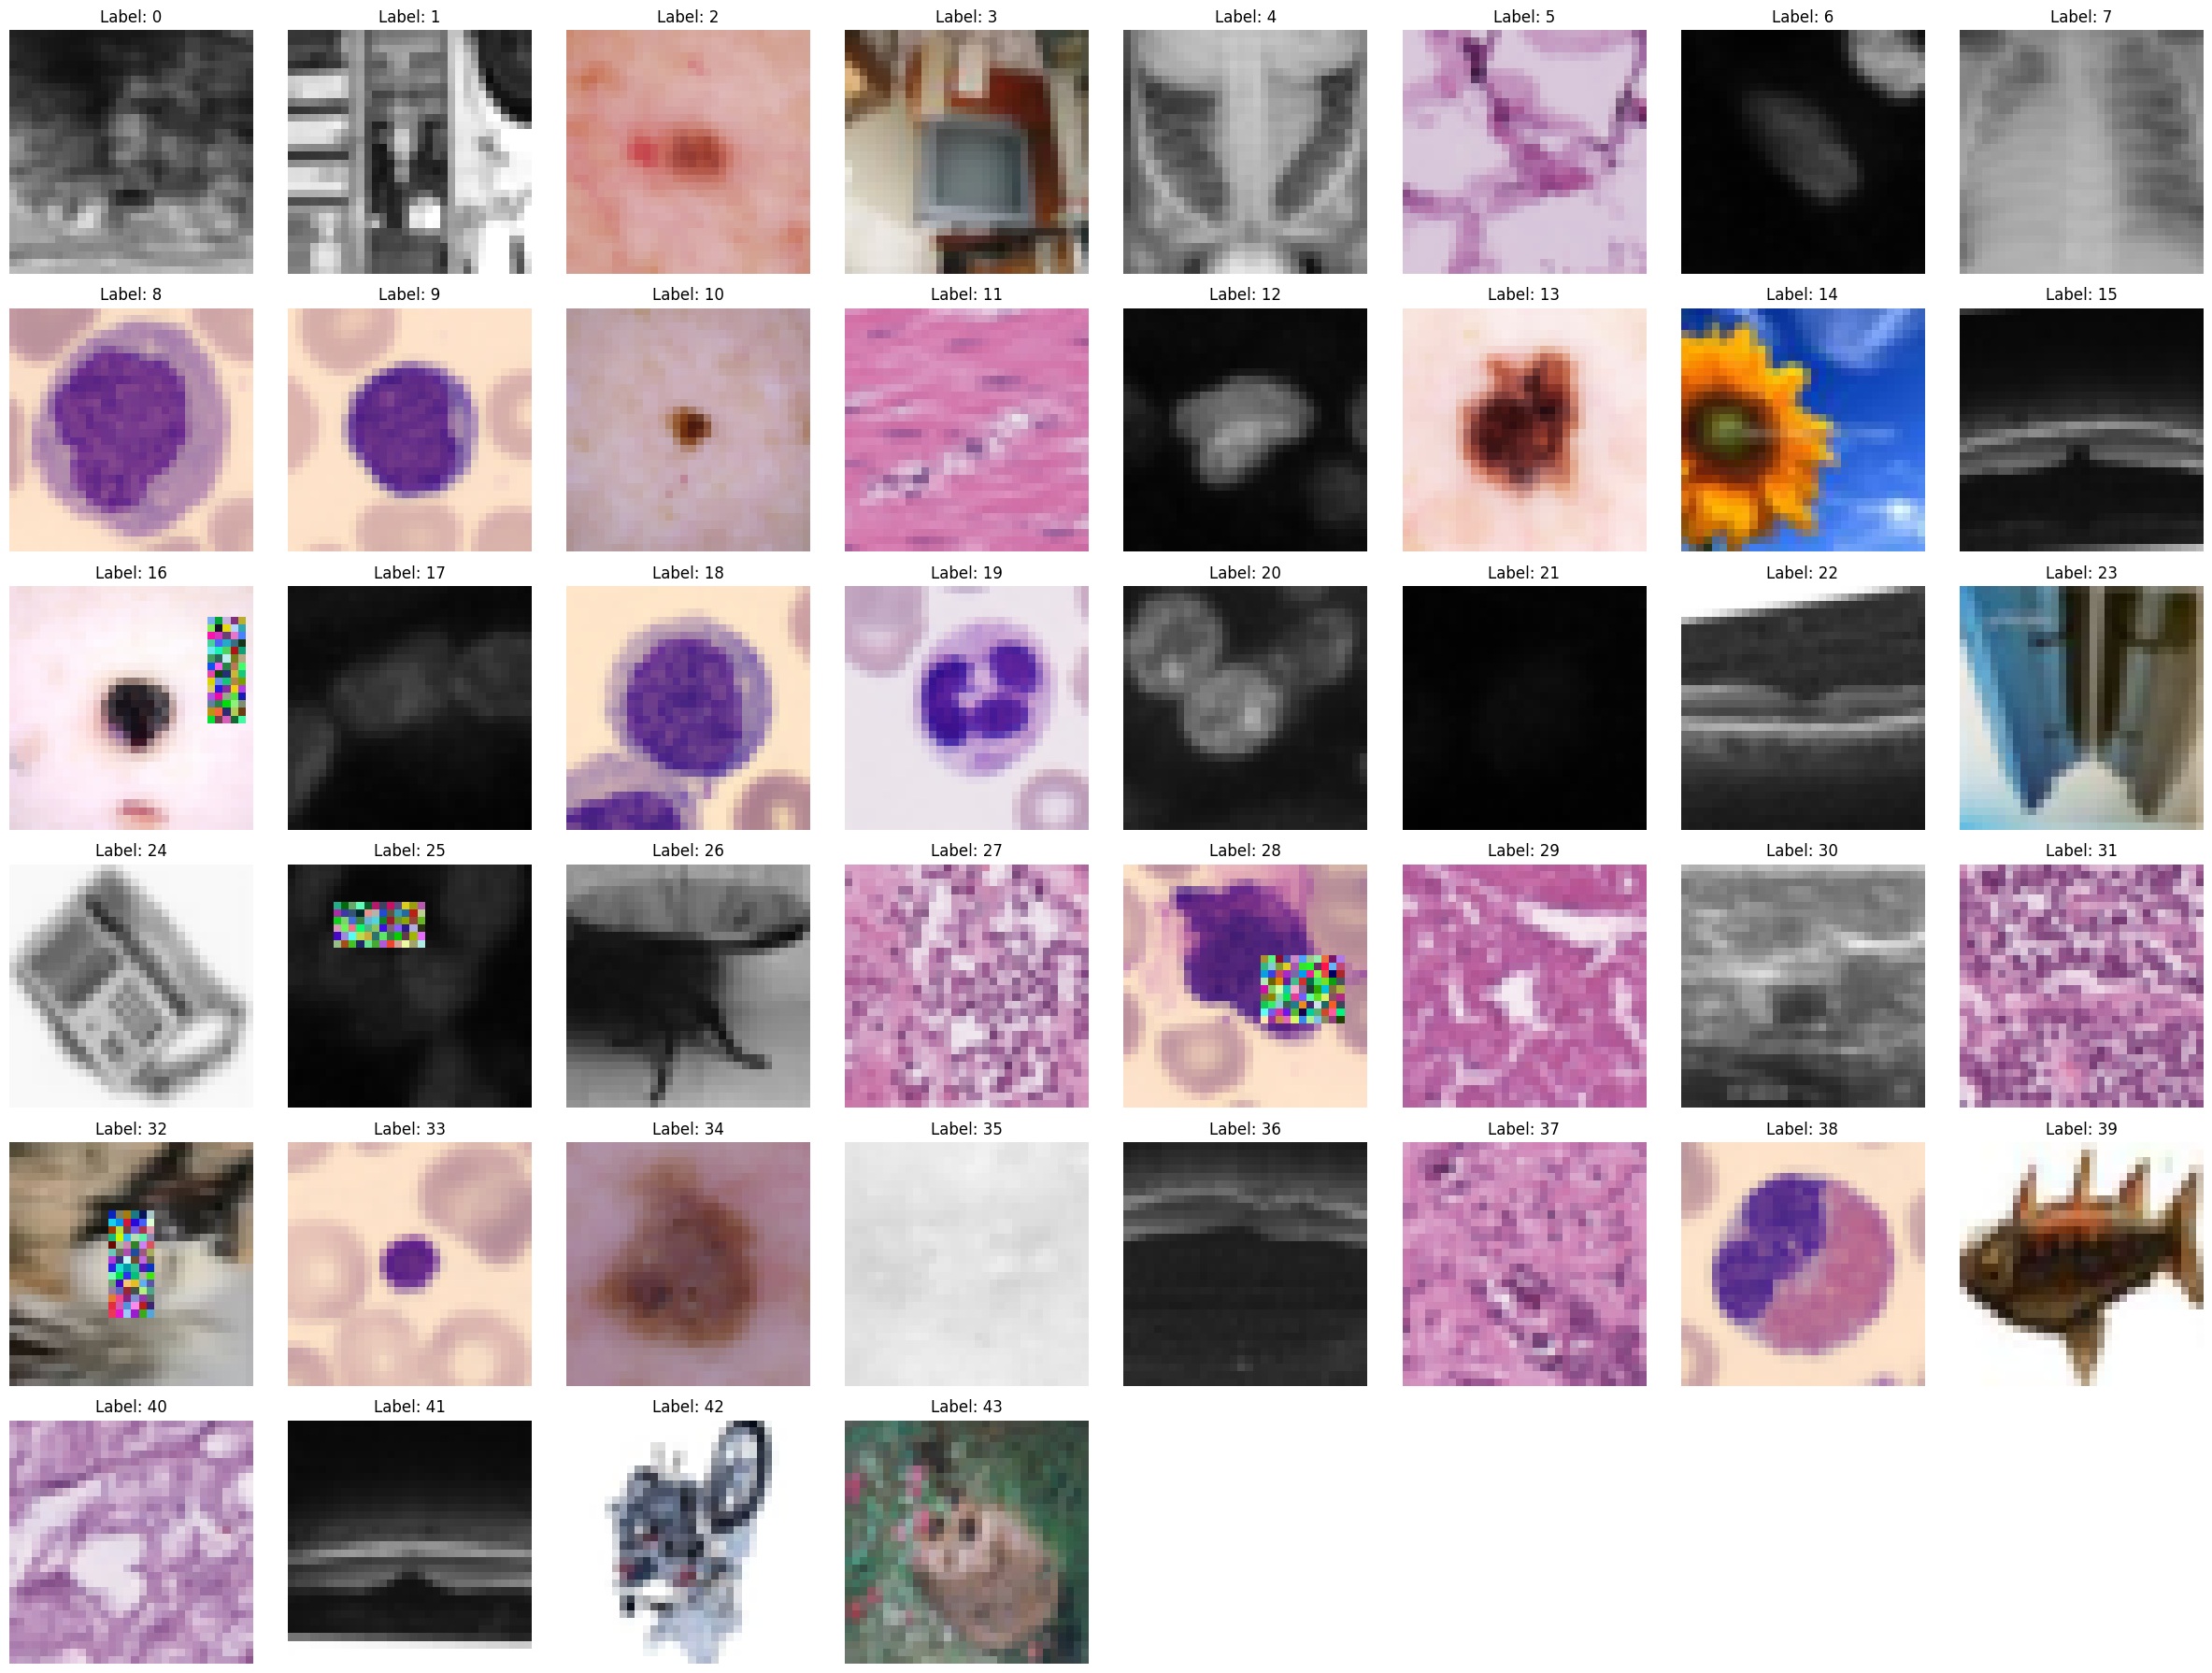

In [31]:
n = len(label_to_sample)
cols = 8
rows = (n + cols - 1) // cols

plt.figure(figsize=(3*cols, 3*rows))

for idx, (label, img_tensor) in enumerate(sorted(label_to_sample.items())):
    img = F.to_pil_image(img_tensor)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model Trainig for classification (member/non-member)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import numpy as np
from collections import Counter

labels = np.array(public_data.labels)
membership = np.array(public_data.membership)
tags = np.array([f"{l}_{m}" for l, m in zip(labels, membership)])
all_indices = np.arange(len(public_data))

# Count tag frequencies
tag_counts = Counter(tags)

# Separate rare samples (tags with < 2 occurrences)
rare_indices = np.array([i for i, tag in enumerate(tags) if tag_counts[tag] < 2])
strat_eligible = np.array([i for i, tag in enumerate(tags) if tag_counts[tag] >= 2])
strat_tags = tags[strat_eligible]

# Stratified train-test split (e.g., 80% train, 20% test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,)
train_idx_r, test_idx_r = next(sss.split(strat_eligible, strat_tags))

# Map back to full dataset indices
train_idx_r = strat_eligible[train_idx_r]
test_idx_r = strat_eligible[test_idx_r]

# Combine rare indices with train set (rare samples only go to train to keep them in dataset)
train_idx = np.concatenate([rare_indices, train_idx_r])
test_idx = test_idx_r

# Wrap in Subset for PyTorch DataLoader compatibility
train_data = Subset(public_data, train_idx)
test_data = Subset(public_data, test_idx)

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 16000, Test size: 4000


In [4]:
from collections import defaultdict

def check_distribution_across_splits(train_idx, test_idx, dataset):
    # Prepare tag mapping
    def get_tags(indices):
        return [f"{dataset.labels[i]}_{dataset.membership[i]}" for i in indices]

    all_tags = get_tags(np.arange(len(dataset)))
    unique_tags = sorted(set(all_tags))

    tag_counts = defaultdict(lambda: {"train": 0, "test": 0, "total": 0})

    for idx in train_idx:
        tag = f"{dataset.labels[idx]}_{dataset.membership[idx]}"
        tag_counts[tag]["train"] += 1
        tag_counts[tag]["total"] += 1

    for idx in test_idx:
        tag = f"{dataset.labels[idx]}_{dataset.membership[idx]}"
        tag_counts[tag]["test"] += 1
        tag_counts[tag]["total"] += 1

    # Print header
    print(f"{'Tag':<10} {'Train':>7} {'Test':>7} {'Total':>7} | {'Train %':>8} {'Test %':>8}")
    print("-" * 70)

    for tag in sorted(tag_counts.keys()):
        info = tag_counts[tag]
        total = info["total"]
        train_pct = 100 * info["train"] / total if total else 0
        test_pct = 100 * info["test"] / total if total else 0
        print(f"{tag:<10} {info['train']:>7}  {info['test']:>7} {total:>7} | {train_pct:7.2f}%  {test_pct:7.2f}%")

In [5]:
check_distribution_across_splits(train_idx, test_idx, public_data)

Tag          Train    Test   Total |  Train %   Test %
----------------------------------------------------------------------
0_0             14        3      17 |   82.35%    17.65%
0_1              7        2       9 |   77.78%    22.22%
10_0           118       29     147 |   80.27%    19.73%
10_1           123       31     154 |   79.87%    20.13%
11_0           288       72     360 |   80.00%    20.00%
11_1           302       75     377 |   80.11%    19.89%
12_0           400      100     500 |   80.00%    20.00%
12_1           361       90     451 |   80.04%    19.96%
13_0            17        4      21 |   80.95%    19.05%
13_1            20        5      25 |   80.00%    20.00%
14_0            18        4      22 |   81.82%    18.18%
14_1            14        4      18 |   77.78%    22.22%
15_0           230       57     287 |   80.14%    19.86%
15_1           278       69     347 |   80.12%    19.88%
16_0             3        0       3 |  100.00%     0.00%
16_1             3 